# Entwicklung der empirischen Modelle

Inhaltsverzeichnis
- [Monte Carlo](#monte-carlo-simulation)
- [Logit](#variante-2-logistisches-regressionsmodel-der-fensteröffnung)

## Importe

In [1]:
#### Jupyter Einstellungen

%load_ext autoreload
%autoreload 2

#### Python Importe

from zoneinfo import ZoneInfo
import locale
import warnings
import datetime as dt
import time
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import math
import numpy as np
import pandas as pd
from pandas import IndexSlice as IDX

locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')
tz = ZoneInfo('Europe/Berlin')

import RomansThesis as RT
from RomansThesis import getDB, getLüftungsStats, getLüftungen, getLüftungsDatasets, removeUnoccupied, plotCompareLüftungAPP, plotLüftung, BUID, ROOMS, APPS, DB, IND, AMB

DB

Lade WetterDB...
Lade Raumklima...
Lade gespeicherte Datenbank...                                                                


bui                          LB                                           \
app                           N                                            
room                          B                                            
value                     HK_IO  Rh Rh_amb T_amb T_amb_g24 Tair Thk Tset   
Datetime                                                                   
2021-02-08 11:00:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:01:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:02:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:03:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:04:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
...                         ...  ..    ...   ...       ...  ...  ..  ...   
2022-10-10 01:56:00+02:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2022-10-10 01:57:00+02:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2022-10-10 01:58:00+02:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2022-10-10 01:59:00+02:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2022-10-10 02:00:00+02:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   

bui                                      ...  MW                              \
app                                      ...   S                               
room                                  K  ...  WZ                               
value                     g_abs Fenster  ...  Rh Rh_amb T_amb T_amb_g24 Tair   
Datetime                                 ...                                   
2021-02-08 11:00:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:01:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:02:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:03:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:04:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
...                         ...     ...  ...  ..    ...   ...       ...  ...   
2022-10-10 01:56:00+02:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2022-10-10 01:57:00+02:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2022-10-10 01:58:00+02:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2022-10-10 01:59:00+02:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2022-10-10 02:00:00+02:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   

bui                                               
app                                               
room                                              
value                     Thk Top Tset Tsk g_abs  
Datetime                                          
2021-02-08 11:00:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:01:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:02:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:03:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:04:00+01:00 NaN NaN  NaN NaN   NaN  
...                        ..  ..  ...  ..   ...  
2022-10-10 01:56:00+02:00 NaN NaN  NaN NaN   NaN  
2022-10-10 01:57:00+02:00 NaN NaN  NaN NaN   NaN  
2022-10-10 01:58:00+02:00 NaN NaN  NaN NaN   NaN  
2022-10-10 01:59:00+02:00 NaN NaN  NaN NaN   NaN  
2022-10-10 02:00:00+02:00 NaN NaN  NaN NaN   NaN  

[876361 rows x 408 columns]

# Ermittlung eines Lüftungsmodells

## Monte-Carlo-Simulation

In [2]:
focus_rooms = ['SZ', 'WZ', 'K']
_kind = 'box'
catkwargs = {'box': {'kind':'box'}, 'violin' :{'kind':'violin', 'cut':0}}

FREQ = '15min'

In [3]:
def createWindowSignal(freq, nSims, p_Window, d_Lüftungen, n_Lüftungen, exportto=None):
    '''
    freq:
        Simulationszeitschritt
    nSims:
        Anzahl der zu erstellenden Varianten
    p_Window:
        Verteilungsfunktion der Fensteröffnung
    d_Lüftung:
        Grundgesamtheit der Lüftungsdauern
    n_Lüftung:
        Grundgesamtheit der Lüftungsanzahlen
    '''
    def getDuration(df, freq, d_Lüftungen, n_Lüftungen):
        '''
        df:
            Fenstersignal (0, 1) für jeden Zeitschritt
        freq:
            Zeitschritt der Simulation
        d_Lüftungen:
            Grundgesamheit der Lüftungsdauern pro Tag
        n_Lüftungen:
            Grundgesamtheit der Lüftungsanzahl
        '''

        def _getDuration(x, freq):
            '''
            x: 
                row mit Argument "Fenster" (0, 1)
            freq:
                Simulationszeitschritt
            Berechne die Lüftungsdauer pro Lüftungsvorgang.

            Vorgehen:
            1)  Wenn für ein Fenster eine Fensteröffnung definiert wurde, ziehe eine zufällige Öffnungsdauer pro Tag und eine zufällige Öffnungsanzahl pro Tag aus der Grundgesamtheit.
            
            2)  Berechne die die Dauer der einzelnen Lüftung aus $\frac{d_{Lüftung}}{n_{Lüftung}}$

            3)  Berechne den Zeitpunkt der Fensterschließung T_{close}

            '''
            if x.Fenster:
                dur, = d_Lüftungen.groupby('Jahreszeit').get_group(x.season).dropna().sample().Öffnungsdauer
                n, = n_Lüftungen.groupby('Jahreszeit').get_group(x.season).dropna().sample().Öffnungsanzahl
                if n == 0:  return np.NaN
                else:   return pd.to_timedelta(dur/n, unit='H').round(freq)
            else:   return np.NaN
        _df = pd.to_timedelta(df.apply(lambda x: _getDuration(x, freq=freq), axis=1).dropna())
        _df = _df.to_frame().reset_index().set_axis(['open', 'close'], axis=1)
        _df['close'] = _df.open+_df.close
        return _df.stack().drop_duplicates(keep=False).reset_index(1).set_axis(['value', 'Datetime'], axis=1).set_index('Datetime').sort_index().reindex(df.index, method='ffill').replace(['close', np.NaN, 'open'], [False, False, True])
    
    dfs = []
    for i in range(nSims):
        window_signal = pd.DataFrame(index=pd.date_range('2021-01-01', '2022-01-01', freq=freq, inclusive='left'))
        window_signal['season'] = RT.utils.getSeason(window_signal.index)
        window_signal['HoD'] = window_signal.index.hour
        window_signal[f'p'] = window_signal.apply(lambda x: p_Window.loc[x.HoD, x.season], axis=1)
        window_signal[f't'] = window_signal.apply(lambda x: np.random.default_rng().uniform(0, 1), axis=1)
        window_signal[f'Fenster'] = window_signal[f'p'] > window_signal[f't']
        dfs.append(getDuration(window_signal, freq, d_Lüftungen, n_Lüftungen).set_axis([f'MC_SIG_{i}'], axis=1))
        window_signal['duration'] = dfs[-1]
    signal = pd.concat(dfs, axis=1)
    
    if exportto is not None:
        dirname = os.path.dirname(exportto)
        if not os.path.isdir(dirname) : os.makedirs(dirname)
        signal.astype('float').to_csv(exportto, index=False, index_label='HoY')

    return window_signal, signal

1. Bestimmung der Lüftungshäufigkeit nach Jahreszeiten
   1. Alle Daten
   2. Bereionigt von Außreisern

Öffnungsanzahl: 11% Outliner (IQR=-7.5, 12.5) entfernt
Öffnungsanzahl: 4% Outliner (IQR=-9.0, 15.0) entfernt
Öffnungsanzahl: 4% Outliner (IQR=-9.0, 15.0) entfernt


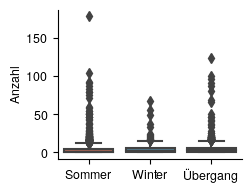

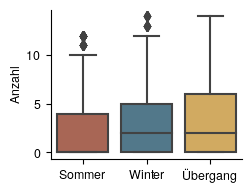

In [4]:
n_Lüftungen = DB.loc[:,IDX[:,:,focus_rooms,'Fensteröffnung']].gt(0).groupby(level=[0,1], axis=1).max().resample('D').sum().stack([0,1]).rename('Öffnungsanzahl').reset_index()
n_Lüftungen['Jahreszeit'] = RT.utils.getSeason(n_Lüftungen.Datetime)
fig = plt.figure(**RT.size(0.3, fr=0.4))
ax = sns.boxplot(data=n_Lüftungen, x='Jahreszeit', y='Öffnungsanzahl', palette=RT.CLRS)
ax.set(title='Mit Ausreissern')
ax.set(title=None, ylabel='Anzahl', xlabel=None)
fig.tight_layout(pad=0.1)

n_Lüftungen = RT.utils.removeOutliner(n_Lüftungen, col='Öffnungsanzahl',by='Jahreszeit')
fig = plt.figure(**RT.size(0.3, fr=0.4))
ax = sns.boxplot(data=n_Lüftungen, x='Jahreszeit', y='Öffnungsanzahl', palette=RT.CLRS)
ax.set(title='Bereinigt von Außreisern')
ax.set(title=None, ylabel='Anzahl', xlabel=None)
fig.tight_layout(pad=0.1)

2. Lüftungsdauer
   1. Alle Daten
   2.  Bereinigt von Außreisern

Öffnungsdauer: 2% Outliner (IQR=-24.4, 40.6) entfernt
Öffnungsdauer: 10% Outliner (IQR=-3.8, 6.2) entfernt
Öffnungsdauer: 8% Outliner (IQR=-10.5, 17.5) entfernt


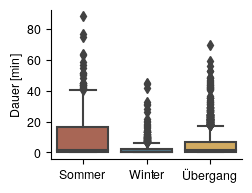

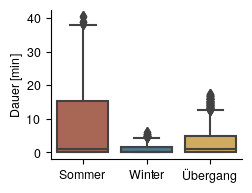

In [5]:
d_Lüftungen = DB.loc[:,IDX[:,:,focus_rooms,'Fenster']].groupby(level=[0,1], axis=1).max().resample('D').sum().stack([0,1]).rename('Öffnungsdauer').reset_index()
d_Lüftungen['Jahreszeit'] = RT.utils.getSeason(d_Lüftungen.Datetime)
d_Lüftungen['Öffnungsdauer'] = d_Lüftungen['Öffnungsdauer'].where(lambda x: x == 0, lambda x: x.apply(lambda x1: pd.to_timedelta(x1, unit='min')).round(FREQ).dt.total_seconds()/60/60)
fig = plt.figure(**RT.size(0.3, fr=0.4))
ax = sns.boxplot(data=d_Lüftungen, x='Jahreszeit', y='Öffnungsdauer', palette=RT.CLRS)
ax.set(title='Mit Ausreissern')
ax.set(title=None, ylabel='Dauer [\si{\minute}]', xlabel=None)
fig.tight_layout(pad=0.1)

d_Lüftungen = RT.utils.removeOutliner(d_Lüftungen, col='Öffnungsdauer', by='Jahreszeit')
fig = plt.figure(**RT.size(0.3, fr=0.4))
ax = sns.boxplot(data=d_Lüftungen, x='Jahreszeit', y='Öffnungsdauer', palette=RT.CLRS)
ax.set(title='Bereinigt von Außreisern')
ax.set(title=None, ylabel='Dauer [\si{\minute}]', xlabel=None)
fig.tight_layout(pad=0.1)

3. Erstelle Verteilungsfunktion über den Tagesverlauf

In [6]:
df = DB.loc[:, IDX[:,:,focus_rooms,'Fensteröffnung']].groupby(level=[0,1], axis=1).max()
df = removeUnoccupied(df[df > 0].resample(FREQ).max().fillna(0))
df = df.groupby(df.index.date).cumsum(skipna=True).mean(axis=1).reset_index()
df['season'] = RT.utils.getSeason(df.Datetime)
df = df.set_index(['season','Datetime'])
df = df.groupby(['season', df.index.get_level_values(1).hour + df.index.get_level_values(1).minute/60]).mean()
P = df.groupby('season').diff().fillna(0).unstack('season').stack().reset_index().rename(columns={0:'value'})
CDF = df.unstack('season').stack().reset_index().rename(columns={0:'value'})

    1. Wahrscheinlichkeitsdichte

,Datetime,season,value
0,0.00,Sommer,0.000000
1,0.00,Winter,0.000000
2,0.00,Übergang,0.000000
3,0.25,Sommer,0.023551
4,0.25,Winter,0.018182


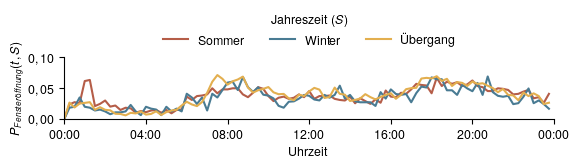

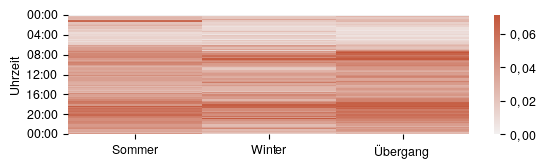

In [7]:
# Lineplot
fig = plt.figure(**RT.size(.3))
ax = sns.lineplot(data=P, x='Datetime', y='value', hue='season', palette=RT.CLRS)
ax.set(ylabel='$P_{Fensteröffnung}(t, S)$', xlabel='Uhrzeit $(t)$')
#fig.suptitle('Wahrscheinlichkeitverteilung der Fensteröffnung über den Tag')
sns.move_legend(ax, bbox_to_anchor=[.5,1], loc='lower center', ncol=3, frameon=False, title='Jahreszeit $(S)$')
ax.set_ylim(0,0.1)
RT.datemapaxis(ax, 'x')
fig.tight_layout()

#   Heatmap
fig = plt.figure(**RT.size(.3))
ax = sns.heatmap(data=P.pivot_table(columns='season', index='Datetime', values='value'),vmin=0, annot=False, fmt='.2f', cmap=RT.Reds)
#fig.suptitle('Häufigkeitskeitverteilung der Fensteröffnung über den Tag')
ax.set(ylabel='Uhrzeit $(t)$', xlabel=None)
RT.datemapaxis(ax)
fig.tight_layout()

P.head()

    2. Kummulierte Wahrscheinlichkeitsdichte

,Datetime,season,value
0,0.00,Sommer,0.327899
1,0.00,Winter,0.077273
2,0.00,Übergang,0.171852
3,0.25,Sommer,0.351449
4,0.25,Winter,0.095455


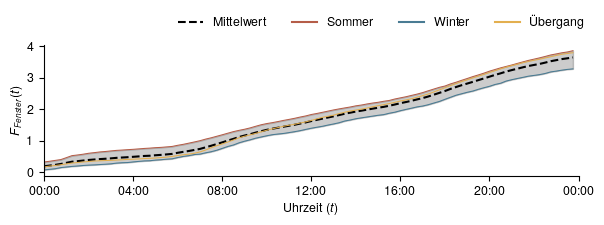

In [8]:
## Schritt 2A: All-in-One
fig = plt.figure(**RT.size(.3))
ax = sns.lineplot(data=CDF, x='Datetime', y='value', color='k', linestyle='dashed', label='Mittelwert')
ax = sns.lineplot(data=CDF, x='Datetime', y='value', hue='season', palette=RT.CLRS, lw=.75)
ax.get_legend().remove()
ax.set(xticks=np.arange(0,26,2), xlim=(0,24), xlabel='Tageszeit', title='CDF "separiert"')
RT.datemapaxis(ax, 'x')
fig.legend(ncol=4, bbox_to_anchor=(1,1), loc='lower right')
ax.set(title=None, xlabel='Uhrzeit $(t)$', ylabel='$F_{Fenster}(t)$')
fig.tight_layout(pad=0.1)
CDF.head()

4. Erstelle Vorhersage für eine Jahreszeit und berechne SSE als Gütemaß

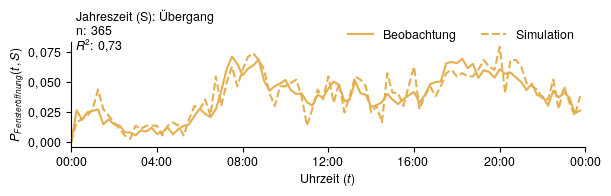

In [9]:
from sklearn.metrics import r2_score
focus = ('Übergang')
p_Window = P.pivot_table(values='value', index='Datetime', columns=['season']).rename_axis('HoD')
rng = np.random.default_rng(5)
n = 365
pred_Window = pd.concat([pd.Series(rng.uniform(0,1,24*4), index=p_Window.index) < p_Window[focus] for i in range(n)]).reset_index().rename(columns={'index':'HoD', 0:'FensterIO'})
SSE = np.power(p_Window[focus] - pred_Window.groupby('HoD').mean().squeeze(), 2).sum()
r2 = r2_score(p_Window[focus], pred_Window.groupby('HoD').mean().squeeze()).round(2)
fig = plt.figure(**RT.size(.3))
ax = sns.lineplot(data=p_Window[focus], color=RT.CLRS[focus], label='Beobachtung')
ax = sns.lineplot(data=pred_Window.groupby('HoD').mean().squeeze(), color=RT.CLRS[focus], ls='dashed', label='Simulation')
sns.move_legend(ax, bbox_to_anchor=[1,.9], loc='lower right', frameon=False, ncol=3, title=None)
ax.text(0.01,.9,f'Jahreszeit (S): {focus}\nn: {n}\n$R^2$: {r2:.2n}', transform=ax.transAxes, ha='left', va='bottom')
RT.datemapaxis(ax, 'x')
ax.set(xlabel='Uhrzeit $(t)$', ylabel='$P_{Fensteröffnung}(t, S)$')
fig.tight_layout(pad=0.1)

5. Erstelle eine Vorhersage für ein Ganzes Jahr

In [10]:
window_signal, signal = createWindowSignal(
    freq = FREQ, 
    nSims = 1, 
    p_Window = p_Window, 
    d_Lüftungen = d_Lüftungen, 
    n_Lüftungen = n_Lüftungen,
    #exportto = './sim/robust-inputs/MC_signal.csv'
    )
window_signal

,season,HoD,p,t,Fenster,duration
2021-01-01 00:00:00,Winter,0,0.000000,0.354984,False,False
2021-01-01 00:15:00,Winter,0,0.000000,0.031001,False,False
2021-01-01 00:30:00,Winter,0,0.000000,0.043752,False,False
2021-01-01 00:45:00,Winter,0,0.000000,0.380746,False,False
2021-01-01 01:00:00,Winter,1,0.019697,0.582615,False,False
...,...,...,...,...,...,...
2021-12-31 22:45:00,Winter,22,0.024024,0.697620,False,False
2021-12-31 23:00:00,Winter,23,0.025526,0.755106,False,False
2021-12-31 23:15:00,Winter,23,0.025526,0.733500,False,False
2021-12-31 23:30:00,Winter,23,0.025526,0.827199,False,False


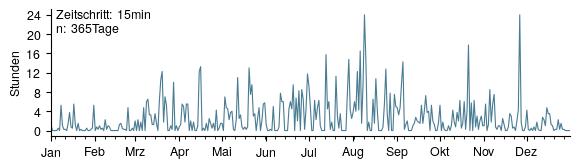

In [11]:
fig = plt.figure(**RT.size(.3))
df = window_signal['duration'].resample('H').mean().resample('D').sum()
ax = df.plot(lw=.8)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(steps=[1,2,4,6,10]))
ax.set(ylabel='Stunden')
ax.set_yticks(np.arange(0,28,4))
ax.xaxis.set_major_locator(mpl.dates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
ax.text(0.01,1,f'Zeitschritt: {FREQ}\nn: {len(window_signal.resample("D").size())}Tage', transform=ax.transAxes, ha='left', va='top')
fig.tight_layout()

6. Vergleiche die Vorhersage mit den Messdaten

In [12]:
window_observations = DB.loc[:,IDX[:,:,['SZ'],['Fenster']]].resample('H').mean().resample('D').sum(min_count=1).dropna(how='all').groupby(level=[0,1,3], axis=1).mean()
_df = (window_observations.stack([0,1])
                    .reset_index(drop=True)
                    .join(signal.sample(axis=1).resample('H').mean().resample('D').sum().reset_index(drop=True).squeeze().rename('Simulation'))
                    .stack()
                    .reset_index(1)
                    .join(pd.Series('SZ', name='room')).fillna(method='ffill')
                    .set_axis(['type', 'Fenster', 'room'],axis=1)
                    .reset_index(drop=True)
                    .replace({'Fenster': 'Beobachtung'})
                    )
df = _df.pivot(columns = 'type', values='Fenster')

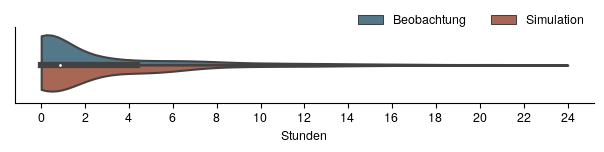

In [13]:
fig = plt.figure(**RT.size(.2))
ax = sns.violinplot(data=_df.replace(RT.NAMES), x='Fenster', y='room', hue='type', cut=0, split=True, orient='h')
ax.set(ylabel=None, xlabel='Stunden')
ax.set_xticks(np.arange(0,26,2))
ax.get_legend().remove()
ax.yaxis.set_visible(False)
fig.legend(ncol=2, bbox_to_anchor=(1,.9), loc='lower right')
fig.tight_layout(pad=0.1)

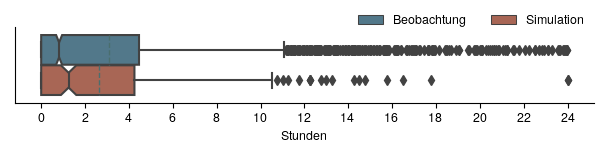

In [14]:
fig = plt.figure(**RT.size(.2))
ax = sns.boxplot(data=_df.replace(RT.NAMES), y='room', x='Fenster', hue='type', orient='horizontal', meanline=True, showmeans=True, notch=True)
ax.set(ylabel=None, xlabel='Stunden')
ax.get_legend().remove()
ax.set_xticks(np.arange(0,26,2))
ax.yaxis.set_visible(False)
fig.legend(ncol=2, bbox_to_anchor=(1,.9), loc='lower right')
fig.tight_layout(pad=0.1)

<AxesSubplot:xlabel='beobachtete Quantile [-]', ylabel='erwartete Quantile [-]'>

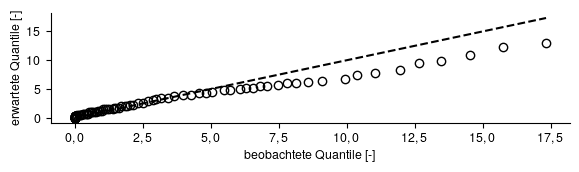

In [15]:
RT.stats.qqplot(df.iloc[:,0].dropna(), df.iloc[:,1].dropna(), test='None', plot_kws=dict(markerfacecolor='none', markeredgecolor='k'))

## Variante 2) Logistisches Regressionsmodel der Fensteröffnung
___
[Zum Import](#importe)

In [16]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

from RomansThesis import getOccupied, removeUnoccupied, removeHolidays, getData, TexMapper
from time import time
import itertools

def exportLogModel(scaler, classifier, y=None, timestep=1, n=5, path='sim/robust-inputs', export=True, TexName=None):
    params = pd.DataFrame([scaler.mean_, scaler.scale_, classifier.coef_[0], classifier.intercept_], index = ['mean', 'scale', 'coeff', 'intercept'], columns = scaler.feature_names_in_).rename(columns={'Übergang':'Uebergang'})
    scale = 1
    if y is not None:
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_ind = le.fit_transform(y)
        if not all(np.in1d(classifier.classes_, le.classes_)):
            raise ValueError("classes should have valid labels that are in y")

        recip_freq = len(y) / (len(le.classes_) * np.bincount(y_ind).astype(np.float64))
        weight = recip_freq[le.transform(classifier.classes_)]
        scale = (weight/weight[0])[1]

    proba = pd.DataFrame(np.random.default_rng().uniform(0,1*scale, (8760*int(1/timestep), n)), columns = [f'LogReg_PROBA_{i}' for i in range(n)])

    if export:
        params.to_csv(os.path.join(path, 'logreg_params.csv'))
        proba.to_csv(os.path.join(path, 'logreg_proba.csv'), index=False, index_label='HoY')
        
    if TexName is not None:
        exportParameterTable(params, filename=f'LogReg_params_{TexName}')
    print(params)
    return params, proba

def exportParameterTable(params, filename='LogReg_params'):
    (params
    .rename(index = {'coeff': r'$\beta_k$', 'intercept': r'$\beta_0$', 'mean': r'$\overline{x}_k$', 'scale':r'$\sigma_k$'},columns=TexMapper)
    .rename_axis(['Prädikatoren'], axis=1)
    .style
    .format(precision=1, escape='latex')
    .to_latex(
        f'./LaTex/tbls/tbl_emp_{filename}.tex',
        caption='Bestimmte Regressionskoeffizienten $\\beta_k$, $\\beta_0$ sowie die Skalierungsfaktoren $\\overline{x}_k$ und $\\sigma_k$ für die ausgewählten Prädiktoren',
        clines="skip-last;data",
        siunitx=True,
        hrules=True,
        position= 'H',
        position_float="centering",
        multicol_align="|c|",
        label='tbl:ParamsRegression')
        )

def Regressionsanalyse(dataset=None, exog=None, CRIT=None, ci=95, ax=None, toTex=None, hist_kws=dict(), **axis_kws):
    if dataset is not None and exog is None and CRIT is None: 
        if dataset.shape[1] == 2:
            exog = dataset.columns[0]
            CRIT = dataset.columns[1]
            df = dataset
    elif exog is not None and CRIT is not None and dataset is None:
        df = pd.concat([exog, CRIT], axis=1)
        exog = exog.Name
        CRIT = exog.CRIT
    elif dataset is not None and isinstance(exog, str) and isinstance(CRIT, str):
        df = dataset[[exog, CRIT]]
    else:
        raise AttributeError('Inputs falsch definiert')
    
    data = df.where(lambda x: x[exog].between(*RT.stats.ci(x[exog], which=ci))).dropna()
    x = data[exog].values.reshape(-1, 1)
    y = data[CRIT]

    scaler = StandardScaler().fit(x)
    rg = LogisticRegressionCV(solver='liblinear', class_weight='balanced', fit_intercept=True).fit(scaler.transform(x), y)

    x_pred = np.linspace(df[exog].min(),df[exog].max(), 100).reshape(-1, 1)

    y_pred = rg.predict_proba(scaler.transform(x_pred))[:,1]
    if ax is None:
        fig, ax = plt.subplots(**RT.size(.4, fraction=.4))
    ax = sns.histplot(data=df, x=exog, y=CRIT, **hist_kws)
    ax.plot(x_pred, y_pred, color=RT.clrs[1], marker='v', markevery=10)
    ax.set(**axis_kws)
    test = f'$\\beta_0$: {rg.intercept_[0]:.2n}\n$\\beta_1$: {rg.coef_[0][0]:.2n}'
    ax.text(0.05,0.85,test, va='top', ha='left', transform=ax.transAxes, bbox=RT.bbox_props)
    ax.grid(axis='both')
    fig.tight_layout()
    if isinstance(toTex, str):
        RT.toTex('desc', f'LogReg_{exog}_{CRIT}_{toTex}')
    return ax

def addInteraction(df, columns_A, columns_B):
    for combo in itertools.product(columns_A, columns_B):
        df['x'.join(combo)] = df[combo[0]] * df[combo[1]]
    return df

In [17]:
CRIT = 'Fenster'
freq = '15min'
feature_names = ['Tair', 'Rh', 'g_abs', 'Rh_amb', 'CO2', 'T_amb', 'T_amb_g24']
dataset = pd.concat(
        [
        getData(value=feature_names, app=['N', 'S'], room=['SZ', 'WZ', 'K'], occupied=True).groupby(level=[0,1,3], axis=1).median().resample(freq).mean().stack([0,1]),
        getData(value=['Fenster'], app=['N', 'S'], room=['SZ', 'WZ', 'K'], occupied=True).where(lambda x: x>0).groupby(level=[0,1,3], axis=1).sum(min_count=1).resample(freq).sum().stack([0,1]),
        getData(value=['Fensteröffnung'], app=['N', 'S'], room=['SZ', 'WZ', 'K'], occupied=True).where(lambda x: x>0).groupby(level=[0,1,3], axis=1).sum(min_count=1).resample(freq).sum().stack([0,1]),
        getData(value=['Fensteröffnung'], app=['N', 'S'], room=['SZ', 'WZ', 'K'], occupied=True).where(lambda x: x<0).groupby(level=[0,1,3], axis=1).sum(min_count=1).resample(freq).sum().stack([0,1]).set_axis(['Fensterschließung'], axis=1).abs()
        ], axis=1).round(2).dropna().reset_index()
dataset = dataset.assign(deltaT = lambda x: x.T_amb - x.Tair)
dataset = dataset.join(AMB[['windspeed', 'global']], on='Datetime').dropna()
steps = 6
DayRange = [f'{x1}h bis {x2}h' for x1, x2 in zip(np.arange(0,24+steps,steps), np.arange(steps, 24+steps, steps))]
dataset = dataset.merge(pd.get_dummies(pd.cut(dataset.Datetime.dt.hour, bins=np.arange(0,24+steps,steps), labels = DayRange, right=False)), right_index=True, left_index=True)
dataset = dataset.merge(pd.get_dummies(RT.utils.getSeason(dataset.Datetime.dt.month)), right_index=True, left_index=True)
fixedEffects = [*DayRange,'Sommer', 'Winter', 'Übergang']
dataset['Fenster'] = (dataset['Fenster'] > 0).astype(int)
dataset['Fensterschließung'] = (dataset['Fensterschließung'] > 0).astype(int)
dataset['Fensteröffnung'] = (dataset['Fensteröffnung'] > 0).astype(int)

dataset = dataset.drop(['bui', 'app', 'Datetime'], axis=1).round(1)
#dataset = addInteraction(dataset, DayRange, ['Sommer', 'Winter', 'Übergang', 'CO2', 'deltaT'])

print(dataset.shape)

dataset.head()

(134969, 20)


,CO2,Rh,Rh_amb,T_amb,T_amb_g24,Tair,g_abs,Fenster,Fensteröffnung,Fensterschließung,deltaT,windspeed,global,0h bis 6h,6h bis 12h,12h bis 18h,18h bis 24h,Sommer,Winter,Übergang
4,517.9,50.8,46.4,6.8,5.9,21.9,8.2,1,1,1,-15.1,1.0,0.2,0,1,0,0,0,0,1
5,743.7,49.1,46.4,6.8,5.9,22.9,8.3,0,0,0,-16.1,1.0,0.2,0,1,0,0,0,0,1
6,523.7,49.9,40.6,8.0,6.4,22.0,8.0,1,0,0,-13.9,0.3,0.2,0,0,1,0,0,0,1
7,778.3,49.6,40.6,8.0,6.4,22.8,8.4,0,0,0,-14.8,0.3,0.2,0,0,1,0,0,0,1
8,514.1,49.3,40.7,7.7,6.8,21.8,8.1,1,1,0,-14.1,1.3,0.2,0,0,1,0,0,0,1


## Zusammenfassung des Datensatzes

In [18]:
(dataset.describe(include='all').T
.rename(columns={'25%':r'$\SI{25}{\percent}$', '50%':r'$\SI{50}{\percent}$', '75%':r'$\SI{75}{\percent}$'}, index=TexMapper)
.rename_axis(['Prädiktoren'])
.style
.format(precision=1, escape='latex')
)

,count,mean,std,min,$\SI{25}{\percent}$,$\SI{50}{\percent}$,$\SI{75}{\percent}$,max
Prädiktoren,,,,,,,,
$CO_2$,134969.0,941.5,537.8,97.7,543.9,800.2,1201.2,4483.3
rH,134969.0,60.7,9.1,28.5,53.6,61.2,67.8,90.7
$rH_{amb}$,134969.0,78.4,18.5,13.2,67.7,82.4,93.3,99.0
$T_{amb}$,134969.0,8.2,7.7,-9.2,2.0,7.6,13.5,38.9
"$T_{amb,g24}$",134969.0,9.4,6.9,-4.7,3.5,8.7,14.9,31.8
$T_{air}$,134969.0,22.0,1.8,11.2,21.0,22.0,23.0,28.8
$g_{abs}$,134969.0,10.2,2.0,3.6,8.8,10.1,11.6,18.8
Fenster,134969.0,0.3,0.5,0.0,0.0,0.0,1.0,1.0
Fensteröffnung,134969.0,0.1,0.2,0.0,0.0,0.0,0.0,1.0


a) Korrelationen

<AxesSubplot:>

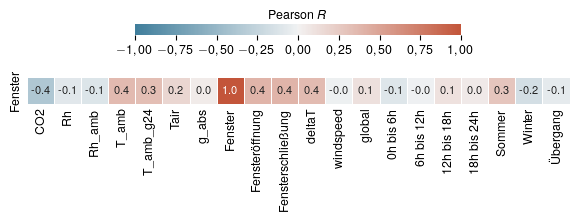

In [19]:
RT.stats.CorreleationMatrix(dataset, highlights=[CRIT])

b) Variance Inflation Factor

<AxesSubplot:>

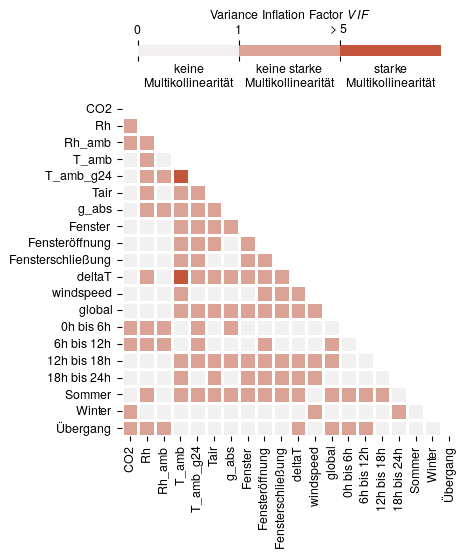

In [20]:
RT.stats.VIFMatrix(dataset, tresh=5, triangular=True, annot=False)

### Demonstration der Skalierung

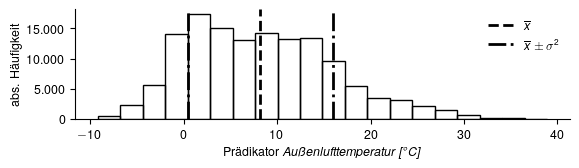

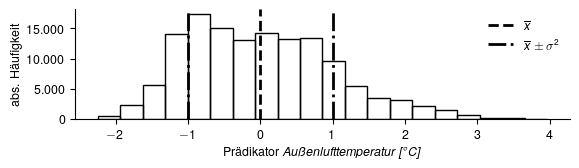

In [21]:
def plotHisto(_x):
    mean_ = _x.mean()
    std_ = _x.std()
    fig = plt.figure(**RT.size(.3))
    ax = sns.histplot(data=_x, bins=20, fill=False, color='k', lw=1)
    ax.axvline(x=mean_, c='k', ls='dashed', lw=2, label=r'$\overline{x}$')
    ax.axvline(x=mean_-std_, c='k', ls='dashdot', lw=2, label=r'$\overline{x}\pm\sigma^2$')
    ax.axvline(x=mean_+std_, c='k', ls='dashdot', lw=2)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(steps=[1,2,5,10]))
    ax.set(xlabel=r'Prädikator \emph{Außenlufttemperatur [\si{\celsius}]}', ylabel=r'abs. Häufigkeit')
    ax.legend()
    fig.tight_layout()

_x = dataset['T_amb']
plotHisto(_x)

mean_ = _x.mean()
std_ = _x.std()
_x = (_x - mean_) / std_
plotHisto(_x)

### Gewichtung

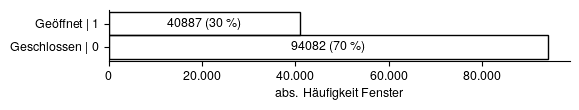

In [22]:
y = dataset[CRIT]

fig = plt.figure(**RT.size(.2))
ax = sns.histplot(y=y, discrete=True, fill=False, color='k', lw=1)
p1 = ax.containers[0]

ax.bar_label(p1, labels = [f'{n} ({pct*100:.2n} \\si{{\\percent}})' for n, pct in zip(y.value_counts(), y.value_counts(normalize=True))], label_type='center')
ax.set(ylabel=None, xlabel=f'abs. Häufigkeit {CRIT}')
ax.set_yticks([0, 1], [r'Geschlossen | 0', r'Geöffnet | 1'])
fig.tight_layout()

## Wahl der Prädikatoren

### 1) SelectFromModel

Grenzwert für Featurewahl: 1
Features selected by SelectFromModel: ['Rh' 'T_amb' 'deltaT']
Done in 28.397s


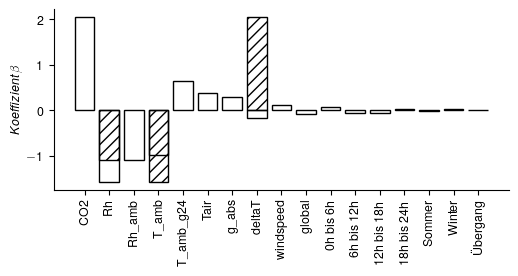

In [23]:
X = dataset.drop([CRIT,'Fensteröffnung', 'Fensterschließung'], axis=1).astype('float')
y = dataset[CRIT].astype('float')

feature_names = np.array(X.columns)

# Scaliere den Datensatz auf Normalverteilung
scaler = StandardScaler().fit(X)

# Führe einen ersten Fit mit Cross-Validation durch.
log_reg = LogisticRegressionCV(solver='liblinear', class_weight='balanced', scoring='roc_auc').fit(scaler.transform(X), y)
importance = pd.DataFrame(log_reg.coef_, columns=feature_names, index=['coef']).T.sort_values('coef', key=abs, ascending=False)

#Auswahl der Prädikatoren
threshold = abs(importance.iat[3, 0]) + 0.01
print(f'Grenzwert für Featurewahl: {threshold:.2n}')

tic = time()
sfm = SelectFromModel(log_reg, threshold=threshold).fit(scaler.transform(X), y)
#sfm = SelectFromModel(log_reg).fit(scaler.transform(X), y)
toc = time()
sfm_features = feature_names[sfm.get_support()]

#Betrachte die Koeffizienten der Prädikatoren und wähle die drei mit dem höchsten Einfluss aus.
fig, ax = plt.subplots(**RT.size(.4))
ax.bar(height=importance.coef, x=feature_names, fill=False, color='k', lw=1)
ax.set(ylabel='$Koeffizient \\beta$')
ax.tick_params(axis='x', labelrotation= 90)
ax.bar(height=importance.loc[sfm_features,:].squeeze(), x=sfm_features, fill=False, hatch='///', color='k', lw=1)
fig.tight_layout

print(f"Features selected by SelectFromModel: {sfm_features}")
print(f"Done in {toc - tic:.3f}s")

                  Rh     T_amb     deltaT
mean       60.693821  8.215781 -13.801970
scale       9.087237  7.742191   6.923934
coeff      -0.540120  0.961031   0.097452
intercept  -0.142521       NaN        NaN


,Rh,T_amb,deltaT
mean,60.693821,8.215781,-13.801970
scale,9.087237,7.742191,6.923934
coeff,-0.540120,0.961031,0.097452
intercept,-0.142521,NaN,NaN


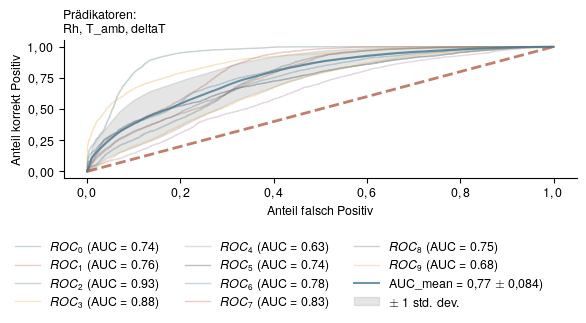

In [24]:
# Trainiere ein neues Modell mit den soeben ausgewählten Prädikatoren
X = dataset[sfm_features].astype('float')
y = dataset[CRIT].astype('float')

logreg, scaler = RT.stats.ROCplot(X, y)
params, t_prob = exportLogModel(scaler, logreg, timestep=.25, n=5,export=False)
params

### 2) Backward Selection

['CO2' 'Rh' 'Rh_amb' 'T_amb' 'T_amb_g24' 'Tair' 'g_abs' 'deltaT'
 'windspeed' 'global' '0h bis 6h' '6h bis 12h' '12h bis 18h' '18h bis 24h'
 'Sommer' 'Winter' 'Übergang']


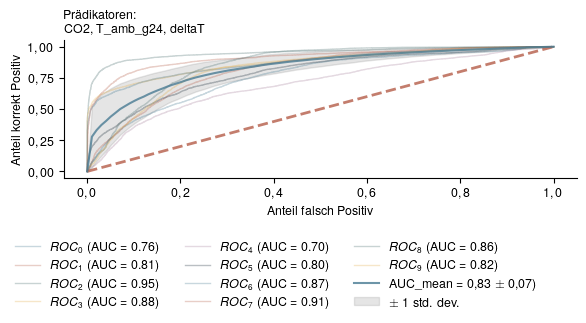

In [26]:
X = dataset.drop([CRIT,'Fensteröffnung', 'Fensterschließung'], axis=1).astype('float')
y = dataset[CRIT].astype('float')

feature_names = np.array(X.columns)
print(feature_names)

scaler = StandardScaler().fit(X)

log_reg = LogisticRegressionCV(solver='liblinear', class_weight='balanced', scoring='roc_auc').fit(scaler.transform(X), y)

# tic_bwd = time()
# sfs_backward = SequentialFeatureSelector(log_reg, n_features_to_select=3, direction="backward").fit(scaler.transform(X), y)
# toc_bwd = time()
# print(
#     "Features selected by forward sequential selection: "
#     f"{feature_names[sfs_backward.get_support()]}"
# )
# print(f"Done in {toc_bwd - tic_bwd:.3f}s")

X = dataset[['CO2', 'T_amb_g24', 'deltaT']].astype('float')
y = dataset['Fenster'].astype('float')

classifier, scaler = RT.stats.ROCplot(X,y)

### 3) Forward Selection

In [27]:
X = dataset.drop([CRIT,'Fensteröffnung', 'Fensterschließung'], axis=1).astype('float')
y = dataset[CRIT].astype('float')

feature_names = np.array(X.columns)
print(feature_names)

scaler = StandardScaler().fit(X)

log_reg = LogisticRegressionCV(solver='liblinear', class_weight='balanced', scoring='roc_auc').fit(scaler.transform(X), y)
importance = pd.DataFrame(log_reg.coef_, columns=feature_names, index=['coef']).T.sort_values('coef', key=abs, ascending=False)

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(log_reg, n_features_to_select=3, direction="forward").fit(scaler.transform(X), y)
toc_fwd = time()
print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

['CO2' 'Rh' 'Rh_amb' 'T_amb' 'T_amb_g24' 'Tair' 'g_abs' 'deltaT'
 'windspeed' 'global' '0h bis 6h' '6h bis 12h' '12h bis 18h' '18h bis 24h'
 'Sommer' 'Winter' 'Übergang']
Features selected by forward sequential selection: ['CO2' 'Winter' 'Übergang']
Done in 749.920s


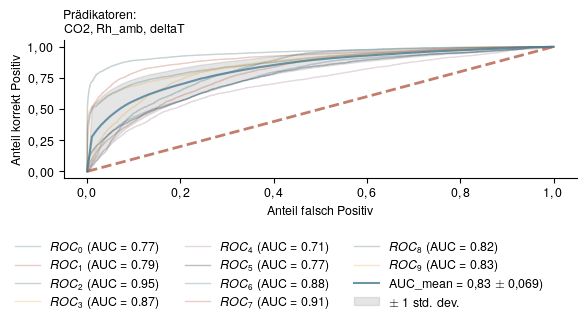

In [28]:
#X = dataset[feature_names[sfs_forward.get_support()]].astype('float')
X = dataset[['CO2', 'Rh_amb', 'deltaT']].astype('float')

y = dataset['Fenster'].astype('float')

classifier, scaler = RT.stats.ROCplot(X,y)

### 4) ROMANs Finale Auswahl

              deltaT         CO2  T_amb_g24
mean      -13.801970  941.494731   9.412258
scale       6.923934  537.819732   6.929442
coeff       0.273518   -1.062035   0.341734
intercept  -0.299467         NaN        NaN


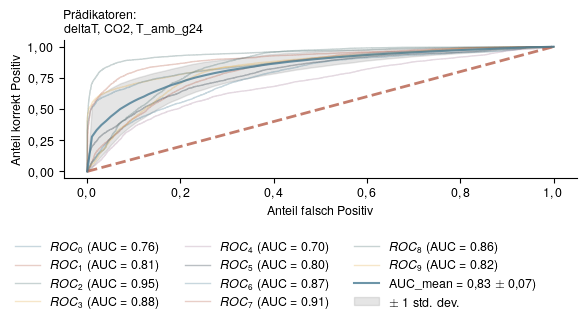

In [30]:
features = ['deltaT', 'CO2', 'T_amb_g24']

X = dataset[features].astype('float')
y = dataset[CRIT].astype('float')
logreg, scaler = RT.stats.ROCplot(X, y)

params, t_prob = exportLogModel(
    scaler, 
    logreg, 
    y,
    timestep=.25,
    n=20,
    #TexName='Model',
    export=False)

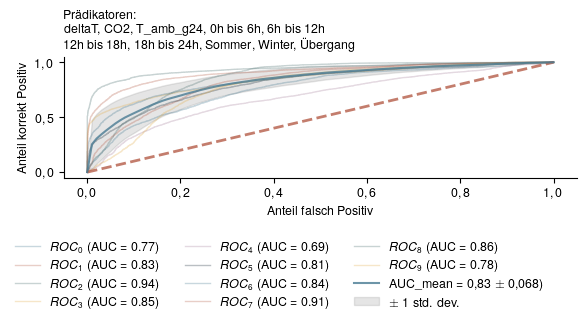

In [31]:
# Trainiere ein neues Modell mit den soeben ausgewählten Prädikatoren
X = dataset[np.append(features, np.array(fixedEffects, dtype='object'))].astype('float')
y = dataset[CRIT].astype('float')

logreg, scaler = RT.stats.ROCplot(X, y)